# DiffRenderGAN – Automatic Mask and Image Generation

This notebook demonstrates how automatic mask generation and synthetic image rendering can be performed after training a DiffRenderGAN model.  
It serves as a continuation of the training workflow presented in `train_diffrendergan.ipynb`.

Here, we focus on the **inference phase**, showing how to:

- Load a trained DiffRenderGAN checkpoint  
- Generate new synthetic microscopy images with corresponding segmentation masks  
- Visualize results

Please note the original experiments and training results presented in the paper are stored in the  
`experiments/` directory.  

Before running this notebook, please ensure that:

1. The **Conda environment** is properly configured and activated  
   (e.g., `conda activate diffrendergan`).  
2. All dependencies are installed from `environment.yml`, and the  
   DiffRenderGAN repository is cloned and accessible in your working directory.


## Install

In [1]:
!git clone https://github.com/dpossart/DiffRenderGAN

Cloning into 'DiffRenderGAN'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 91 (delta 19), reused 90 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (91/91), 72.67 KiB | 2.20 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [1]:
import os
os.chdir("DiffRenderGAN")

In [3]:
!conda env create -f environment.yml || echo "Environment already exists"
!conda activate diffrendergan


CondaValueError: prefix already exists: /home/dennis.possart/miniconda3/envs/ganpaper

Environment already exists


## (Optional) Training
If you have already completed the training using  
[`train_diffrendergan.ipynb`](train_diffrendergan.ipynb),  
you can directly proceed to the inference and mask generation sections below.

However, if you have not trained the model yet or do not have a checkpoint available,  
you can use the pretrained weights provided from the paper results.

These pretrained model weights are stored in the  
`experiments/` directory and correspond to the versions used for the  
results presented in the publication.

## Testing
For generating synthetic microscopy images and masks, we use the `test_gan.py` script.  
The script loads a trained DiffRenderGAN checkpoint, samples meshes, arranges them in the scene, samples from the learned rendering parameter distributions, and produces both images and segmentation masks.

The `--load_tag` parameter selects the experiment folder, and `--load_cp` specifies which checkpoint to load (e.g., best epoch or paper weights).  
The number of generated samples is controlled via `--n_imgs`.

Before rendering starts, the script may spend some time precomputing mesh placement positions.  
These cached spatial configurations were originally used during training.
This preprocessing step is expected and may take several minutes depending on the number of used spatial configurations during training.

To ensure clean mask outputs, small mask artifacts below a minimum pixel area can be removed using `--min_mask_size`.  
If desired, contour dilation can be enabled (`--dilate`) to generate thicker, more visible outline masks.

The background portion threshold (`--bg_portion`) ensures that a minimum percentage of background pixels is present in the final image.  
Samples violating this threshold (e.g., excessive particle coverage) are discarded and resampled.

All outputs are written to the directory specified by `--output_directory`.


In [2]:
TAG="Ruehle2021TiO2_DEMO"
BEST_EPOCH=43
N_IMGS=100
MIN_MASK_SIZE=50
MIN_BG_PORTION=0.15
DILATE_CONTOURS=True

!python test_gan.py \
    --load_tag={TAG} \
    --load_cp={BEST_EPOCH} \
    --output_directory=datasets/Test_{TAG} \
    --n_fakes={N_IMGS} \
    --dilate={DILATE_CONTOURS} \
    --min_mask_size={MIN_MASK_SIZE} \
    --bg_portion={MIN_BG_PORTION}

2025-11-13 15:37:35 WARN  wrk3  [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).
Setting seed:  777
{'mesh_dict': {'mesh_path': 'utils/rendering/meshes/TiO2_2', 'mesh_unit': 0.25, 'mesh_base_sample_limit': 2.5, 'mesh_scale': 1.0, 'mesh_position3d': False, 'mesh_max_agglomerates': 5, 'mesh_size_dist': 'lognormal', 'lognormal_params': {'mu': 0.1, 'sigma': 0.2}, 'particle_placement': 'poisson'}, 'scene_param_dict': {'n_hidden': 128, 'emission1': 1.0, 'emission2': 0.1, 'spp': 121, 'gaussdev': 0.5, 'noise_limit_min': 0.001, 'noise_limit_max': 0.1, 'stage_bsdf_limit_min': 0.01, 'stage_bsdf_limit_max': 0.4, 'particle_bsdf_limit_min': 0.01, 'particle_bsdf_limit_max': 5.0, 'p_base_color': -1.0, 'p_roughness': -1.0, 'p_anisotropic': 0.0, 'p_metallic': 0.0, 'p_spec_trans': 0.0, 'p_specular': 0.5, 'p_spec_tint': -1.0, 'p_sheen': -1.0, 'p_sheen_tint': -1.0, 'p_flatness': 0.0, 'p_clearcoat': 0.0, 'p_clearcoat_gloss': 0.0, 's_base_color': -1.0, 's_roughnes

## Visualization of Synthetic Images and Masks

After running the generation script, you will find synthetic images and their corresponding segmentation masks in the output directory.
In the masks:
1 = particle
2 = contour
The following code loads one example image and its mask and visualizes them

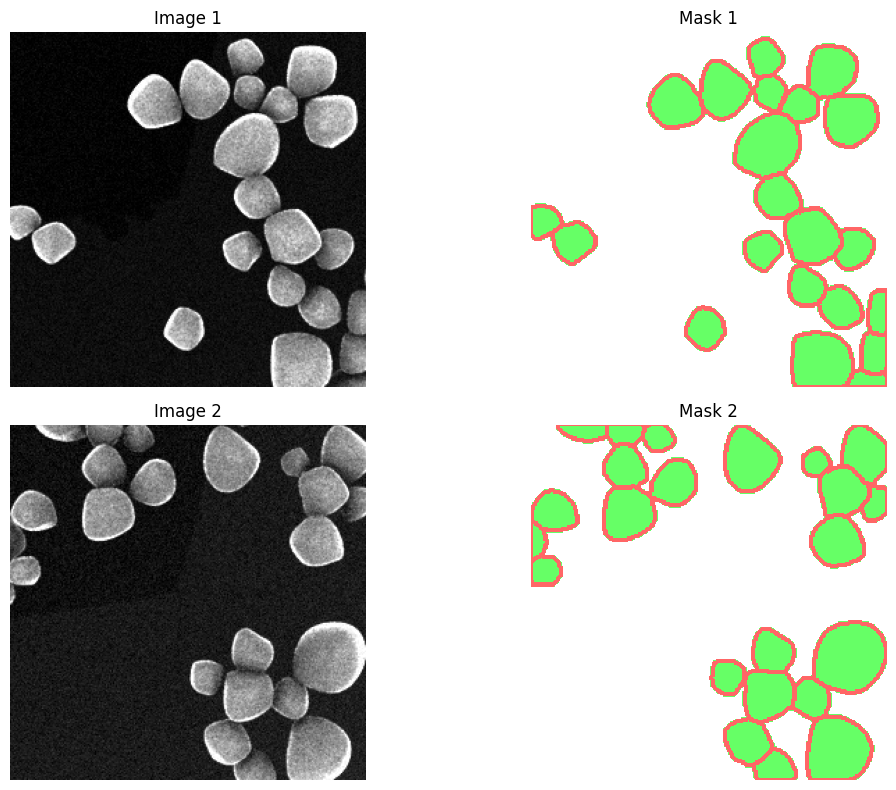

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import os

# Path to generated samples
output_dir = "datasets/Test_Ruehle2021TiO2_DEMO"



# Load first two image mask pairs
img1  = np.array(tiff.imread(os.path.join(f'{output_dir}/imgs', '0.tif')))[0][0]
mask1 = np.array(tiff.imread(os.path.join(f'{output_dir}/masks', '0.tif')))

img2  = np.array(tiff.imread(os.path.join(f'{output_dir}/imgs', '1.tif')))[0][0]
mask2 = np.array(tiff.imread(os.path.join(f'{output_dir}/masks', '1.tif')))

# Color map: 1 = particle (green), 2 = contour (red)
from matplotlib.colors import ListedColormap
cmap = ListedColormap([
    (0, 0, 0, 0),      # background
    (0, 1, 0, 0.6),    # particles
    (1, 0, 0, 0.6)     # contours
])

plt.figure(figsize=(12, 8))

# --- Sample 1 ---
plt.subplot(2, 2, 1)
plt.imshow(img1, cmap="gray")
plt.title("Image 1")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(mask1, cmap=cmap, vmin=0, vmax=2)
plt.title("Mask 1")
plt.axis("off")

# --- Sample 2 ---
plt.subplot(2, 2, 3)
plt.imshow(img2, cmap="gray")
plt.title("Image 2")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(mask2, cmap=cmap, vmin=0, vmax=2)
plt.title("Mask 2")
plt.axis("off")

plt.tight_layout()
plt.show()